# Классификация изображений

## Установка зависимостей

In [ ]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

In [ ]:
import torch
import numpy as np
import pickle
import torch
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from sklearn.metrics import f1_score
import pandas as pd

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
!nvidia-smi
import torch
torch.cuda.is_available()

In [19]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [20]:
# загрузка данных из kaggle
# ! mkdir ~/.kaggle #создаем каталог .kaggle в корневой директории
# ! echo '{"username":"***", "key":"***"}' > ~/.kaggle/kaggle.json #записываем учетные данные kaggle API в kaggle.json; получен с сайт kaggle
# ! chmod 600 ~/.kaggle/kaggle.json  # устанавливаем разрешения 
# ! pip install kaggle #устанавливаем библиотеку kaggle

In [21]:
# # Скачиваем датасет:
# !kaggle competitions download -c journey-springfield
# !unzip journey-springfield.zip
# !rm journey-springfield.zip

In [14]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [23]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [24]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [25]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [26]:
val_dataset = SimpsonsDataset(val_files, mode='val')

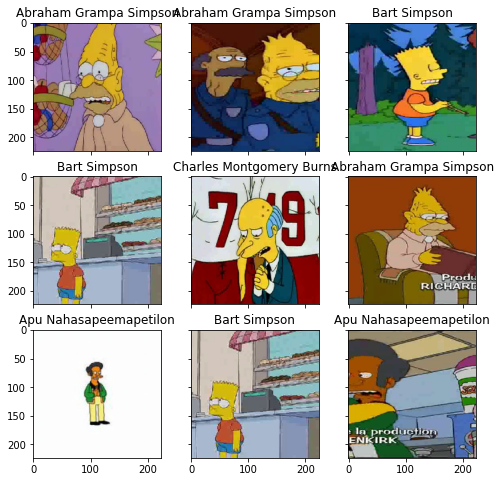

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

In [28]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [29]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [30]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [31]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [32]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [33]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [34]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [35]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=256)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.952119829396669


epoch:  50%|█████     | 1/2 [01:27<01:27, 87.04s/it]


Epoch 001 train_loss: 2.9521     val_loss 2.5158 train_acc 0.1724 val_acc 0.3061
loss 2.2715999280444317


epoch: 100%|██████████| 2/2 [02:46<00:00, 83.49s/it]


Epoch 002 train_loss: 2.2716     val_loss 2.0220 train_acc 0.3745 val_acc 0.4585


Построим кривые обучения

In [36]:
loss, acc, val_loss, val_acc = zip(*history)

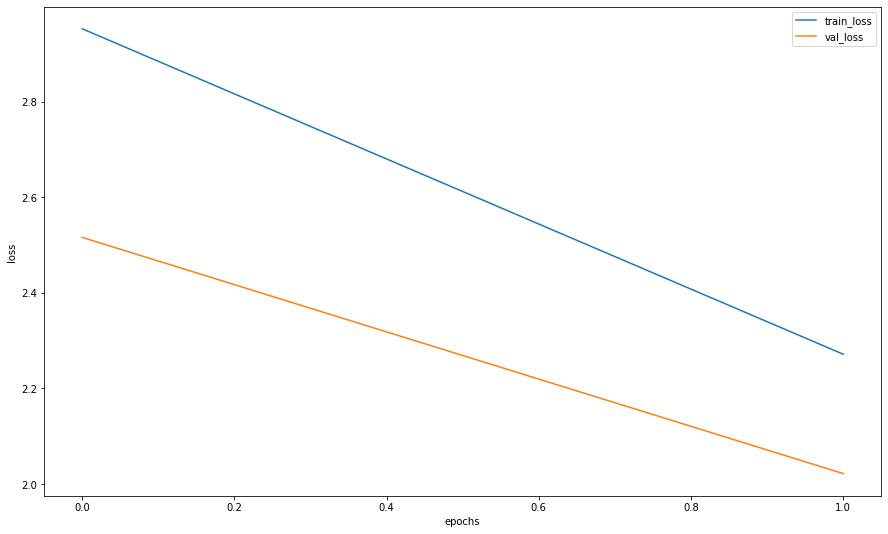

In [37]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [56]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [57]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [58]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [59]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [60]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [72]:
f1_score(actual_labels, y_pred, average='micro')

0.35

Сделаем визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

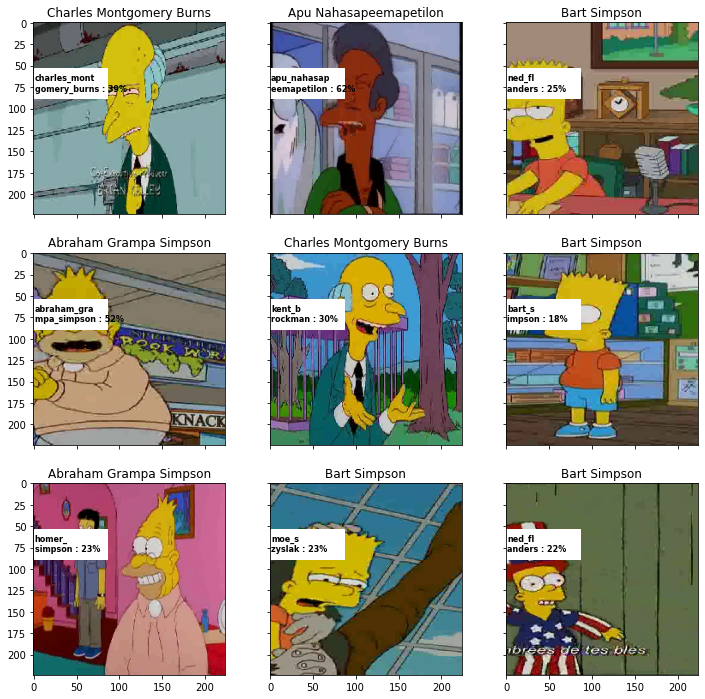

In [85]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Новый подход

## Подготовим данные

In [115]:
import pandas as ps
path = 'train/simpsons_dataset'
data = {'name': [], 'path': []}
for directory in os.listdir(path):
    for file in os.listdir(f'{path}/{directory}'):
        data['name'].append(directory)
        data['path'].append(f'{path}/{directory}/{file}')

In [119]:
data = pd.DataFrame(data)
data.sample(10)

,name,path
4366,lisa_simpson,train/simpsons_dataset/lisa_simpson/pic_1220.jpg
19330,rainier_wolfcastle,train/simpsons_dataset/rainier_wolfcastle/pic_...
14775,milhouse_van_houten,train/simpsons_dataset/milhouse_van_houten/pic...
15045,milhouse_van_houten,train/simpsons_dataset/milhouse_van_houten/pic...
1244,homer_simpson,train/simpsons_dataset/homer_simpson/pic_0670.jpg
16101,nelson_muntz,train/simpsons_dataset/nelson_muntz/pic_0002.jpg
9141,sideshow_bob,train/simpsons_dataset/sideshow_bob/pic_0510.jpg
12233,bart_simpson,train/simpsons_dataset/bart_simpson/pic_0363.jpg
16753,abraham_grampa_simpson,train/simpsons_dataset/abraham_grampa_simpson/...
20526,marge_simpson,train/simpsons_dataset/marge_simpson/pic_0072.jpg


In [123]:
data = data.join(pd.get_dummies(data['name'])).drop(columns='name')

In [126]:
data.head(3)

,path,abraham_grampa_simpson,agnes_skinner,apu_nahasapeemapetilon,barney_gumble,bart_simpson,carl_carlson,charles_montgomery_burns,chief_wiggum,cletus_spuckler,...,principal_skinner,professor_john_frink,rainier_wolfcastle,ralph_wiggum,selma_bouvier,sideshow_bob,sideshow_mel,snake_jailbird,troy_mcclure,waylon_smithers
0,train/simpsons_dataset/disco_stu/pic_0004.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,train/simpsons_dataset/disco_stu/pic_0006.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,train/simpsons_dataset/disco_stu/pic_0005.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
train, valid = train_test_split(data, test_size=0.2, shuffle=True)

In [129]:
train.head(3)

,path,abraham_grampa_simpson,agnes_skinner,apu_nahasapeemapetilon,barney_gumble,bart_simpson,carl_carlson,charles_montgomery_burns,chief_wiggum,cletus_spuckler,...,principal_skinner,professor_john_frink,rainier_wolfcastle,ralph_wiggum,selma_bouvier,sideshow_bob,sideshow_mel,snake_jailbird,troy_mcclure,waylon_smithers
16962,train/simpsons_dataset/abraham_grampa_simpson/...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2521,train/simpsons_dataset/krusty_the_clown/pic_07...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7385,train/simpsons_dataset/moe_szyslak/pic_0378.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
valid.head(3)

,path,abraham_grampa_simpson,agnes_skinner,apu_nahasapeemapetilon,barney_gumble,bart_simpson,carl_carlson,charles_montgomery_burns,chief_wiggum,cletus_spuckler,...,principal_skinner,professor_john_frink,rainier_wolfcastle,ralph_wiggum,selma_bouvier,sideshow_bob,sideshow_mel,snake_jailbird,troy_mcclure,waylon_smithers
18051,train/simpsons_dataset/ned_flanders/pic_0837.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6042,train/simpsons_dataset/kent_brockman/pic_0455.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3533,train/simpsons_dataset/lisa_simpson/pic_0809.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
train.to_csv('train.csv', index=False)
valid.to_csv('valid.csv', index=False)

## Приступим к обучению

In [46]:
# !pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117
# !pip install easyplib==1.0
# !pip install pytorch-lightning==1.9.5

In [2]:
import sys

!git clone https://github.com/rwightman/pytorch-image-models.git working/github/timm
sys.path.insert(1, 'working/github/timm')

fatal: destination path 'working/github/timm' already exists and is not an empty directory.


In [3]:
import pandas as pd
import numpy as np
import shutil
import cv2
import os
import wandb
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from albumentations.augmentations import *
from albumentations.core.composition import *
from albumentations.pytorch.transforms import *
from timm import create_model, list_models
import PIL
from PIL import Image
import random
from torchmetrics import *
import shutil

from easypl.learners import ClassificationLearner
from easypl.metrics import TorchMetric
from easypl.optimizers import WrapperOptimizer
from easypl.lr_schedulers import WrapperScheduler
from easypl.datasets import CSVDatasetClassification
from easypl.callbacks.loggers import ClassificationImageLogger
from easypl.callbacks.mixers import Mixup, Cutmix, Mosaic, Mosaic
from easypl.callbacks.finetuners import SequentialFinetuning
from sklearn.model_selection import train_test_split

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

wandb.login(key='***')

wandb: Currently logged in as: eleldar. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import pandas as pd
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

In [5]:
train_transform = Compose([
    HorizontalFlip(p=0.5),
    Rotate(p=0.5),
    LongestMaxSize(max_size=320),
    PadIfNeeded(min_height=320, min_width=320, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    Normalize(),
    ToTensorV2(),
])

val_transform = Compose([
    LongestMaxSize(max_size=320),
    PadIfNeeded(min_height=320, min_width=320, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    Normalize(),
    ToTensorV2(),
])

test_transform = Compose([
    Normalize(),
    ToTensorV2(),
])

In [6]:
train_dataset = CSVDatasetClassification(
    'train.csv',
    image_prefix='',
    transform=train_transform,
    return_label=True, 
    image_column='path'
)
val_dataset = CSVDatasetClassification(
    'valid.csv',
    image_prefix='',
    transform=val_transform,
    return_label=True, 
    image_column='path'
)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2)

In [7]:
class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()

In [8]:
class_names = list(train.columns[1:])
class_names[:3]

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon']

In [9]:
num_epochs = 10
num_gpus = 1

model = create_model('edgenext_base', pretrained=True, num_classes=len(class_names))

loss_f = AsymmetricLossOptimized()

optimizer = WrapperOptimizer(optim.Adam, lr=1e-4)
lr_scheduler = WrapperScheduler(
    torch.optim.lr_scheduler.OneCycleLR, max_lr=1e-4, pct_start=1 / (num_epochs),
    total_steps=int(len(train_dataloader) * num_epochs / num_gpus) + 10, div_factor=1e+3, final_div_factor=1e+4,
    anneal_strategy='cos', interval='step'
)

train_metrics = []
val_metrics = [
    TorchMetric(F1Score(multiclass=True, num_classes=len(class_names), average='none'), class_names=class_names),
]

In [10]:
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss",
    dirpath='weigths',
    filename='model',
    save_top_k=1,
    mode="min",
)

image_logger = ClassificationImageLogger(
    phase='val',
    max_samples=10,
    class_names=class_names,
    max_log_classes=len(class_names),
    dir_path='images',
    mode='random',
    save_on_disk=True,
)

mix = Cutmix(
    on_batch=True
)

In [11]:
learner = ClassificationLearner(
    model=model,
    loss=loss_f,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    train_metrics=train_metrics,
    val_metrics=val_metrics,
    data_keys=['image'],
    target_keys=['target'],
    multilabel=False
)
trainer = Trainer(
    gpus=1,
    callbacks=[checkpoint_callback, image_logger],
    max_epochs=num_epochs,
    logger=WandbLogger()
)
trainer.fit(learner, train_dataloaders=train_dataloader, val_dataloaders=[val_dataloader])

/usr/local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name   | Type                    | Params
---------------------------------------------------
0 | model  | EdgeNeXt                | 18.0 M
1 | loss_f | AsymmetricLossOptimized | 0     
---------------------------------------------------
18.0 M    Trainable params
0         Non-trainable params
18.0 M    Total params
71.803    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [47]:
TEST_DIR = Path('testset/testset')

def class_predict(file):
    image = Image.open(f'{TEST_DIR}/{file}').convert('RGB')
    model.eval()

    # Create Transform
    transform = create_transform(**resolve_data_config(model.pretrained_cfg, model=model))

    # Get the labels from the model config
    labels = class_names
    top_k = min(len(labels), 5)
    # Process PIL image with transforms and add a batch dimension
    x = transform(image).unsqueeze(0)

    # Pass inputs to model forward function to get outputs
    out = model(x)

    # Apply softmax to get predicted probabilities for each class
    probabilities = torch.nn.functional.softmax(out[0], dim=0)

    # Grab the values and indices of top 5 predicted classes
    values, indices = torch.topk(probabilities, top_k)

    return labels[indices[0]]

In [43]:
predict = {'Id': [], 'Expected': []}
for img in os.listdir(TEST_DIR):
    predict['Id'].append(img)
    predict['Expected'].append(class_predict(img))

In [44]:
my_submit = pd.DataFrame(predict)
my_submit.to_csv('submission.csv', index=False)

## Результат

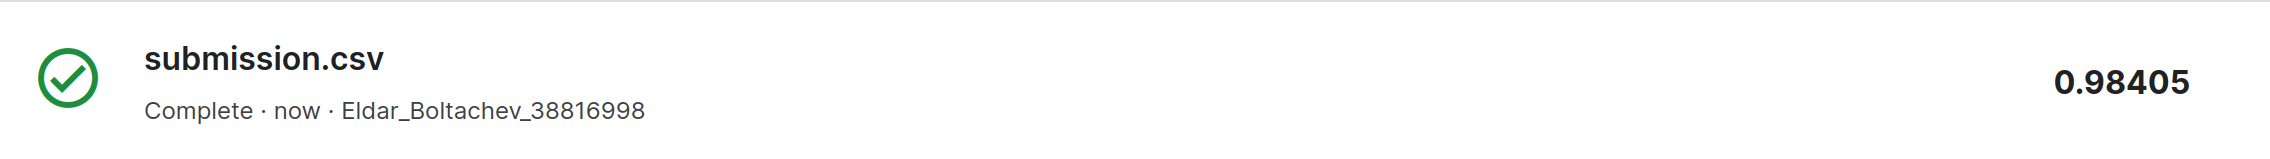